In [2]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../..')
from modules import utils
import tensorflow as tf
import gpflow
from gpflow import set_trainable
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import seaborn as sns
from math import sqrt
from datetime import timedelta
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

#### used devices list

In [4]:
kampala_devices = pd.read_csv('../data/kampala_devices.csv', usecols=['location', 'lat', 'long', 'id'])
kampala_devices.head()

location      id       lat       long
0        Ntinda  930434  0.360209  32.610756
1      Bugolobi  718028  0.307500  32.620600
2  Nantabulirwa  912224  0.346460  32.703280
3        Kireka  930426  0.365500  32.646800
4        Luwafu  930427  0.268900  32.588000

In [5]:
kampala_df = pd.read_csv('../data/kampala_data.csv', parse_dates=['timestamp'])
kampala_df.head()

site_name  latitude  longitude     city  \
0  Civic Centre, Kampala Central  0.317725  32.592509  Kampala   
1  Civic Centre, Kampala Central  0.317725  32.592509  Kampala   
2  Civic Centre, Kampala Central  0.317725  32.592509  Kampala   
3  Civic Centre, Kampala Central  0.317725  32.592509  Kampala   
4  Civic Centre, Kampala Central  0.317725  32.592509  Kampala   

                  timestamp  pm2_5_calibrated_value  pm2_5_raw_value  \
0 2021-09-01 00:00:00+00:00                     NaN              NaN   
1 2021-09-01 01:00:00+00:00                     NaN              NaN   
2 2021-09-01 02:00:00+00:00                     NaN              NaN   
3 2021-09-01 03:00:00+00:00                     NaN              NaN   
4 2021-09-01 04:00:00+00:00                     NaN              NaN   

   pm10_raw_value  pm10_calibrated_value                   site_id  \
0             NaN                    NaN  60d058c8048305120d2d6145   
1             NaN                    NaN  60d058c8048305120d2d6145   
2             NaN                    NaN  60d058c8048305120d2d6145   
3             NaN                    NaN  60d058c8048305120d2d6145   
4             NaN                    NaN  60d058c8048305120d2d6145   

   device_number device_name  
0         689761       aq_26  
1         689761       aq_26  
2         689761       aq_26  
3         689761       aq_26  
4         689761       aq_26

In [6]:
old_latitudes = kampala_df['latitude'].unique()
old_longitudes = kampala_df['longitude'].unique()
old_device_ids = kampala_df['device_number'].unique()
old_site_names = kampala_df['site_name'].unique()
len(old_latitudes), len(old_longitudes), len(old_device_ids), len(old_site_names)

(52, 52, 57, 51)

In [7]:
# final_df = pd.DataFrame()
# cols = ['timestamp', 'latitude', 'longitude', 'pm2_5_calibrated_value', 'device_number', 'site_name']
# devices = []
# for i, row in kampala_devices.iterrows():
#     device_df = get_device_data(kampala_df, row.id, cols)
#     if len(device_df)!=0:
#         devices.append({'device_id':row.id, 'lat':row.lat, 'long':row.long, 'name':row.location})
# len(devices)

pre_final_df = pd.DataFrame()
cols = ['timestamp', 'latitude', 'longitude', 'device_number', 'site_name', 'pm2_5_calibrated_value', ]
for i, device_id in kampala_devices.id.iteritems():
    device_df = utils.get_device_data(kampala_df, device_id, cols)
    processed_df = utils.preprocessing(device_df)
    pre_final_df = pd.concat([pre_final_df, processed_df])
pre_final_df.reset_index(drop=True, inplace=True)
pre_final_df.head()

time  latitude  longitude  device_number       site_name    pm2_5
0  453031.0  0.356989  32.613888         930434  Ntinda, Nakawa  10.5477
1  453032.0  0.356989  32.613888         930434  Ntinda, Nakawa  16.4250
2  453033.0  0.356989  32.613888         930434  Ntinda, Nakawa  17.7239
3  453034.0  0.356989  32.613888         930434  Ntinda, Nakawa  16.1533
4  453035.0  0.356989  32.613888         930434  Ntinda, Nakawa  18.0123

In [9]:
latitudes = pre_final_df['latitude'].unique()
longitudes = pre_final_df['longitude'].unique()
device_ids = pre_final_df['device_number'].unique()
site_names = pre_final_df['site_name'].unique()
len(latitudes), len(longitudes), len(device_ids), len(site_names)

(35, 35, 34, 34)

In [10]:
site_names

array(['Ntinda, Nakawa', 'Bugolobi, Nakawa', 'Nantabulirwa ward, Mukono',
       'Mbalwa, Kira Municipality', 'Luwafu, Makindye', 'Banda, Kampala',
       'Mbuya II, Nakawa', 'Nakasero II, Kampala', 'Kiwatule, Nakawa',
       'Kyaliwajala, Kira Municipality', 'Butabika, Nakawa',
       'Nansana west ward, Wakiso', 'Nansana east ward, Wakiso',
       'Busega, Rubaga', 'Busabala, Wakiso',
       'Mutundwe, Makindye Ssabagabo', 'Kalerwe, Kawempe',
       'Makindye Nsambya/US Embassy', 'Bukoto I, Kawempe',
       'Bukasa, Kira Municipality', 'Kasubi, Rubaga', 'Naguru II, Nakawa',
       'Makindye, Lukuli Makindye', 'Makerere University_01, Kawempe',
       'Rubaga, Kampala', 'Bweyogerere, Wakiso',
       'Bweyogerere, Kira Municipality', 'Civic Centre, Kampala Central',
       'Kiwafu Ward, Wakiso', 'Seguku, Makindye-Ssabagabo',
       'Lukuli, Makindye', 'Najera, Kira Municipality', 'Kasenge, Wakiso',
       'Kisugu, Makindye'], dtype=object)

In [11]:
new_site_names = ['Ntinda', 'Bugolobi', 'Nantabulirwa ward', 'Mbalwa', 'Luwafu', 'Banda', 'Mbuya II', 'Nakasero II',
                  'Kiwatule', 'Kyaliwajala', 'Butabika', 'Nansana West ward', 'Nansana East ward', 'Busega', 
                  'Busabala', 'Mutundwe', 'Kalerwe', 'Nsambya', 'Bukoto I', 'Bukasa', 'Kasubi', 'Naguru II', 
                  'Lukuli', 'Makerere University_01', 'Rubaga', 'Bweyogerere', 'Bweyogerere_02', 'Civic centre',
                  'Kiwafu ward', 'Seguku', 'Lukuli_02', 'Najera', 'Kasenge', 'Kisugu']

In [13]:
final_df = pre_final_df.drop(['device_number', 'site_name'], axis=1)
final_df.head()

time  latitude  longitude    pm2_5
0  453031.0  0.356989  32.613888  10.5477
1  453032.0  0.356989  32.613888  16.4250
2  453033.0  0.356989  32.613888  17.7239
3  453034.0  0.356989  32.613888  16.1533
4  453035.0  0.356989  32.613888  18.0123

In [14]:
f = lambda time: pd.Timestamp.fromtimestamp(time*3600)
f2 = np.vectorize(f)

In [15]:
len(final_df)

48112

In [16]:
len(old_site_names), len(site_names), len(new_site_names)

(51, 34, 34)

In [17]:
def cross_validation(final_df, idx, kernel_variance, lengthscales, likelihood_variance, trainable_kernel, 
                     trainable_variance, trainable_lengthscales):
#     device_indices = final_df[final_df.latitude==latitudes[idx]].index
    device_indices = pre_final_df[pre_final_df.site_name==site_names[idx]].index
    
    test_df = final_df.loc[device_indices]
    train_df = pd.concat([final_df, test_df]).drop_duplicates(keep=False)

    X_train = train_df.iloc[:, 0:-1]
    y_train = train_df.iloc[:, -1]
    X_train, y_train = np.array(X_train), np.array(y_train).reshape(-1, 1)
    if X_train.shape[0] > 39999:
        X_train = X_train[::6, :]
        y_train = y_train[::6, :]
    
    X_test = test_df.iloc[:, 0:-1]
    y_test = test_df.iloc[:, -1]
    X_test, y_test = np.array(X_test), np.array(y_test).reshape(-1, 1)
    
    if lengthscales == 'train_shape':
        lengthscales = np.ones(X_train.shape[1])
    
    if (lengthscales is None) & (kernel_variance is None):
        k = gpflow.kernels.RBF() + gpflow.kernels.Bias()
    elif lengthscales is None:
        k = gpflow.kernels.RBF(variance=kernel_variance) + gpflow.kernels.Bias()
    elif kernel_variance is None:
        k = gpflow.kernels.RBF(lengthscales=lengthscales) + gpflow.kernels.Bias()
    else:
        k = gpflow.kernels.RBF(lengthscales=lengthscales, variance=kernel_variance) + gpflow.kernels.Bias()
 
    m = gpflow.models.GPR(data=(X_train, y_train), kernel=k, mean_function=None)
    if likelihood_variance is None:
        pass
    else:
        m.likelihood.variance.assign(likelihood_variance)
    set_trainable(m.kernel.kernels[0].variance, trainable_kernel)
    set_trainable(m.likelihood.variance, trainable_variance)
    set_trainable(m.kernel.kernels[0].lengthscales, trainable_lengthscales)
    
    opt = gpflow.optimizers.Scipy()
    def objective_closure():
        return - m.log_marginal_likelihood()
    
    opt_logs = opt.minimize(objective_closure,
                            m.trainable_variables,
                            options=dict(maxiter=100))

    mean, var = m.predict_f(X_test)
    rmse = sqrt(mean_squared_error(y_test, mean.numpy()))
    mape = mean_absolute_percentage_error(y_test, mean.numpy())
    return rmse, mape, mean.numpy(), var.numpy(), X_test, y_test
    
#     return mean.numpy(), var.numpy(), Xtest, Ytest, round(rmse, 2)

In [18]:
# lengthscales = [[0.08, 0.08, 1], None, 'train_shape']
lengthscale = [1, 0.08, 0.08]
likelihood_variance = 400
kernel_variance  = 625
trainable_kernel = True
trainable_variance = True
trainable_lengthscale = False

2023-08-17 00:40:31.601787: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-08-17 00:40:31.601826: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: PL1207-PRO.paris.inria.fr
2023-08-17 00:40:31.601831: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: PL1207-PRO.paris.inria.fr
2023-08-17 00:40:31.601965: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.125.6
2023-08-17 00:40:31.601993: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: NOT_FOUND: could not find kernel module information in driver version file contents: "NVRM version: NVIDIA UNIX Open Kernel Module for x86_64  525.125.06  Release Build  (dvs-builder@U16-A23-14-1)  Tue May 30 05:12:48 UTC 2023
GCC version:  gcc ve

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
930434 - Ntinda successful


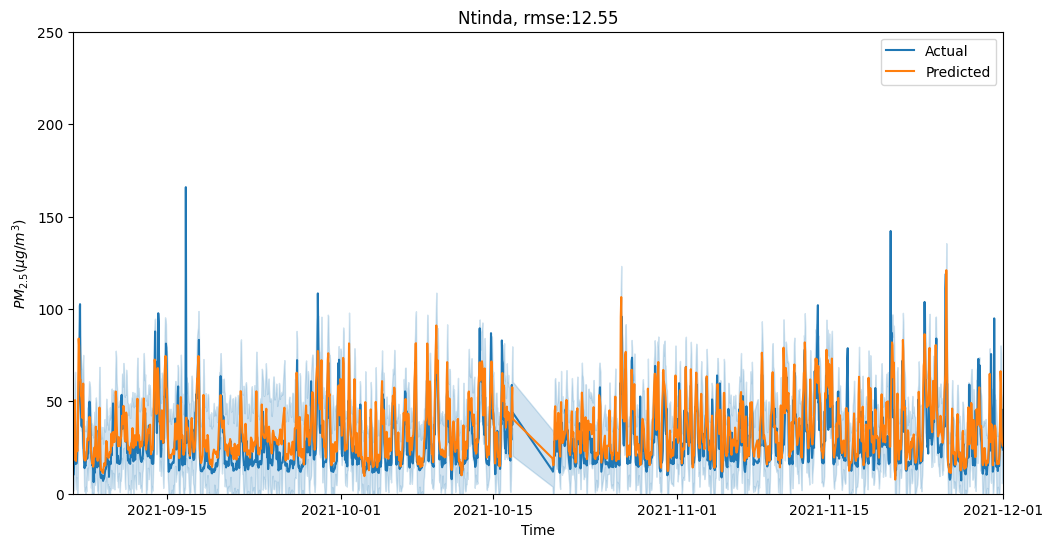

718028 - Bugolobi successful


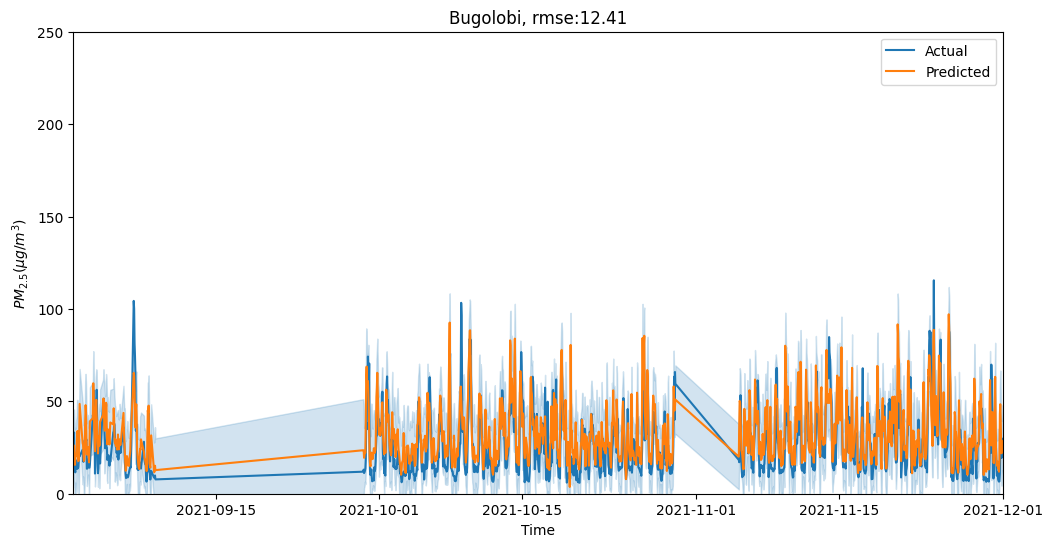

912224 - Nantabulirwa ward successful


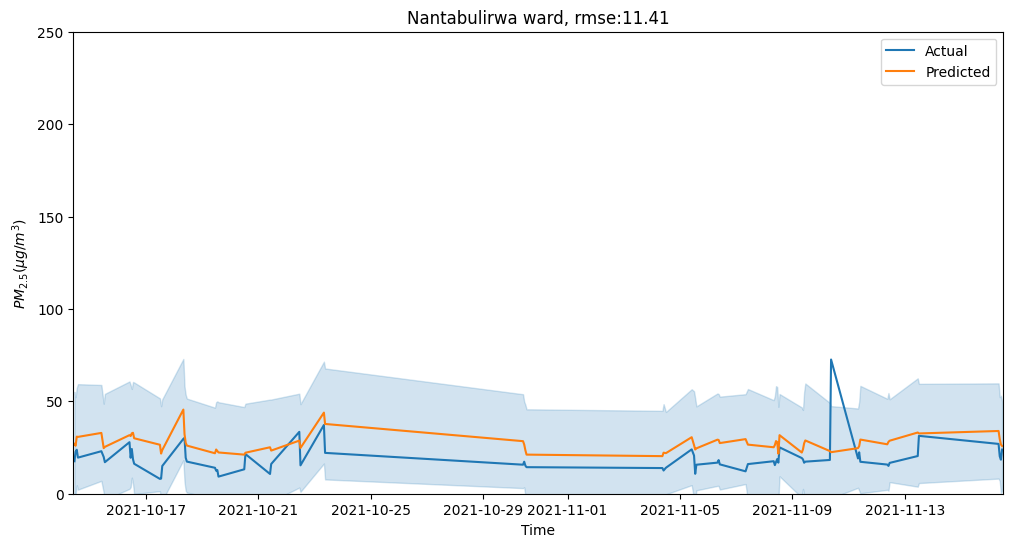

930426 - Mbalwa successful


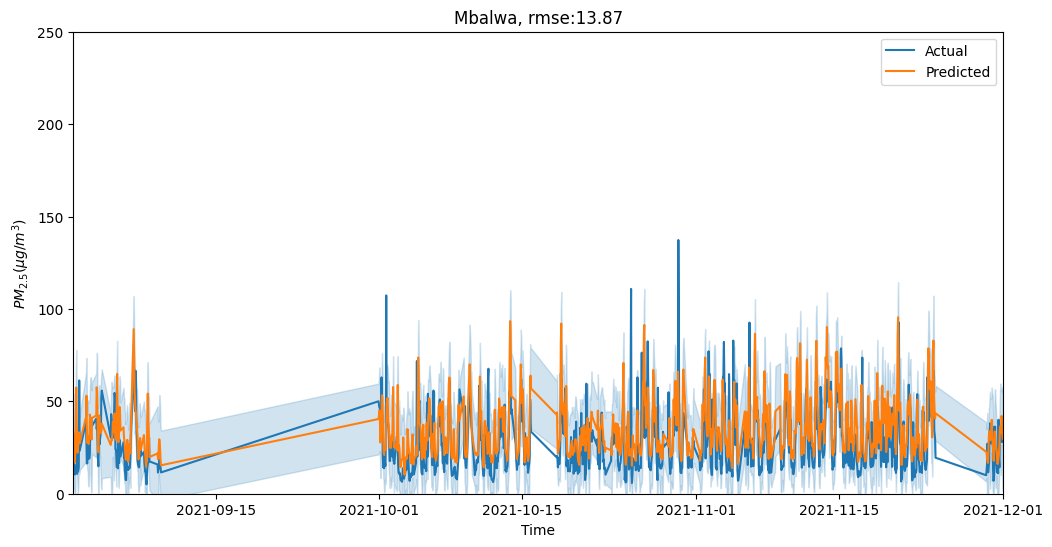

930427 - Luwafu successful


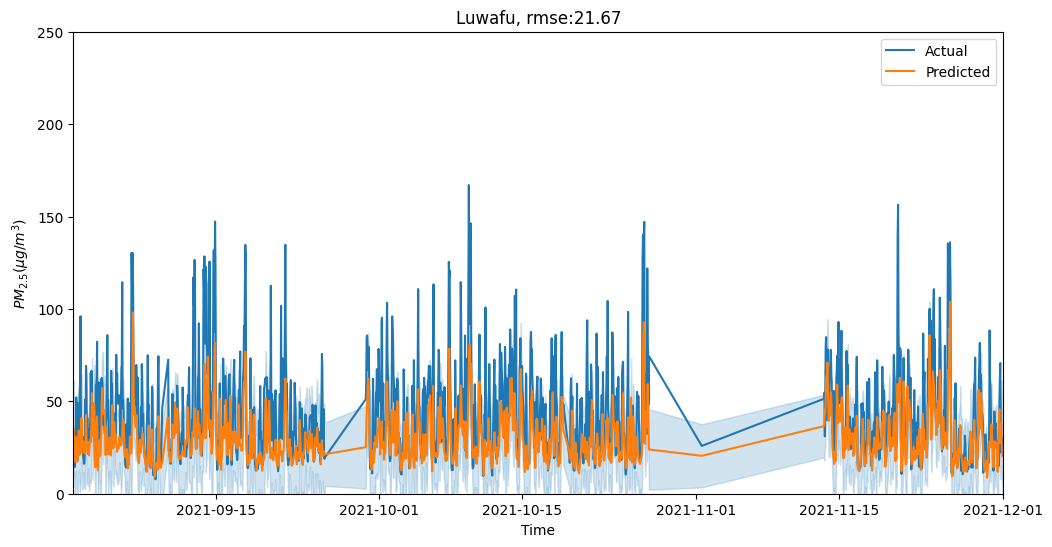

912223 - Banda successful


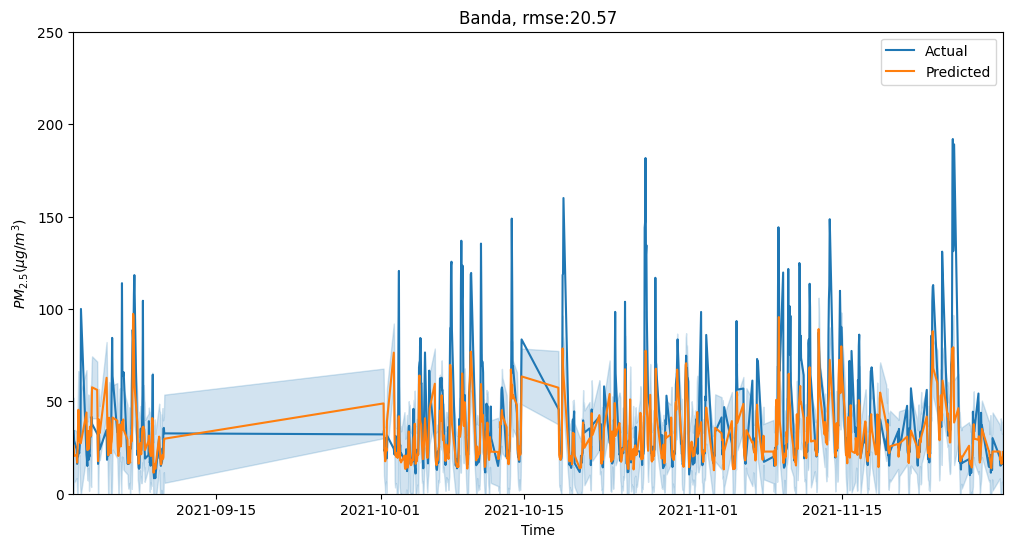

912222 - Mbuya II successful


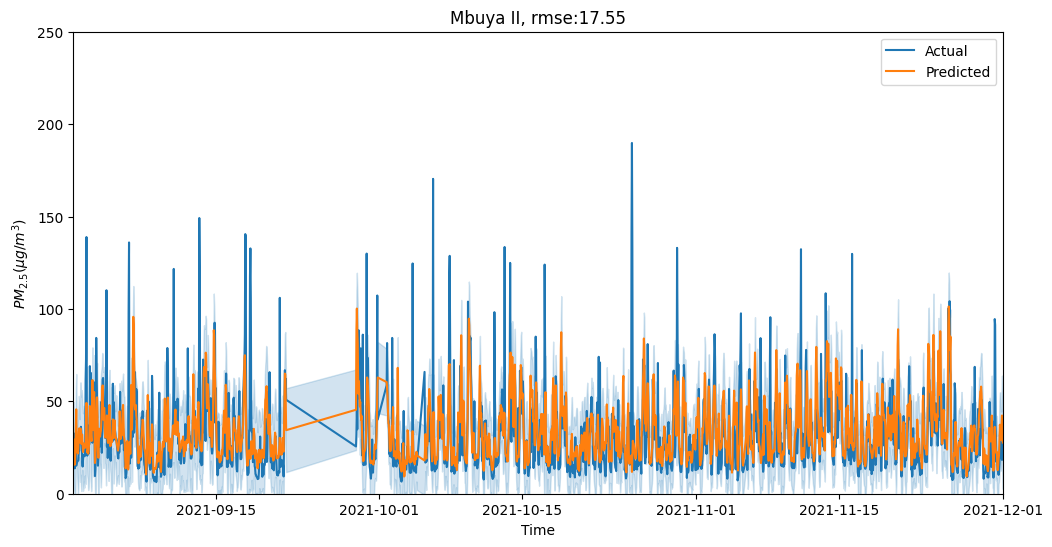

912220 - Nakasero II successful


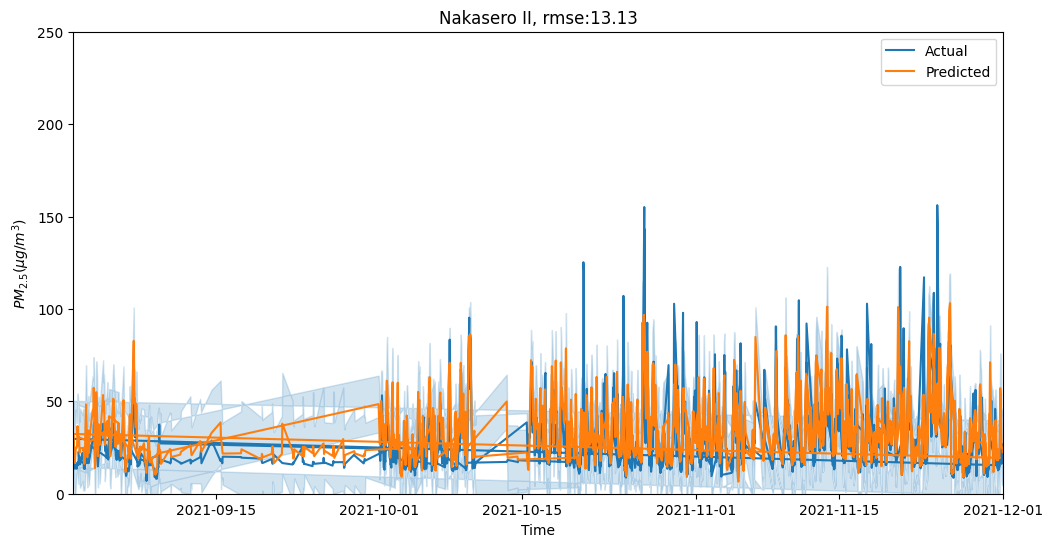

870145 - Kiwatule successful


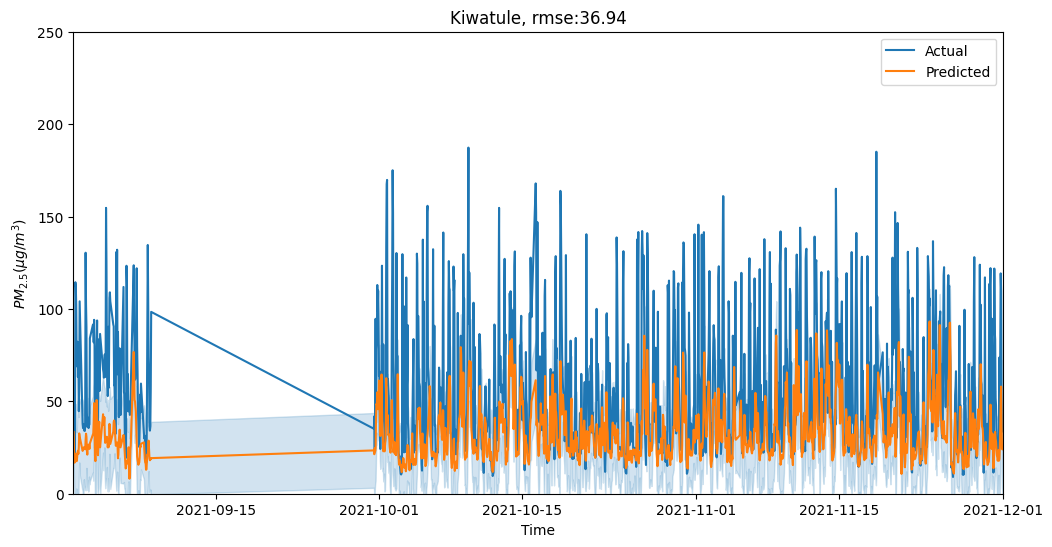

870143 - Kyaliwajala successful


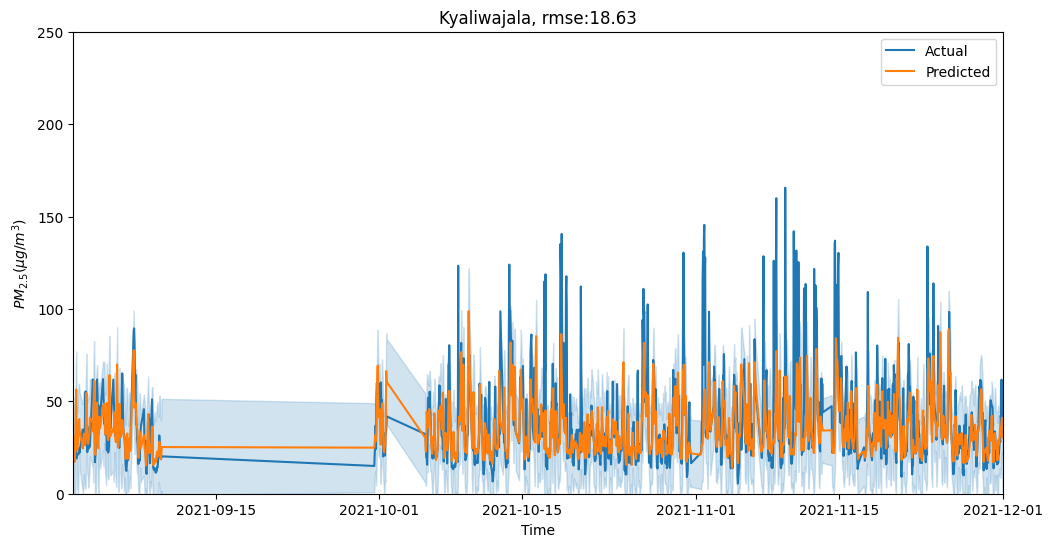

870144 - Butabika successful


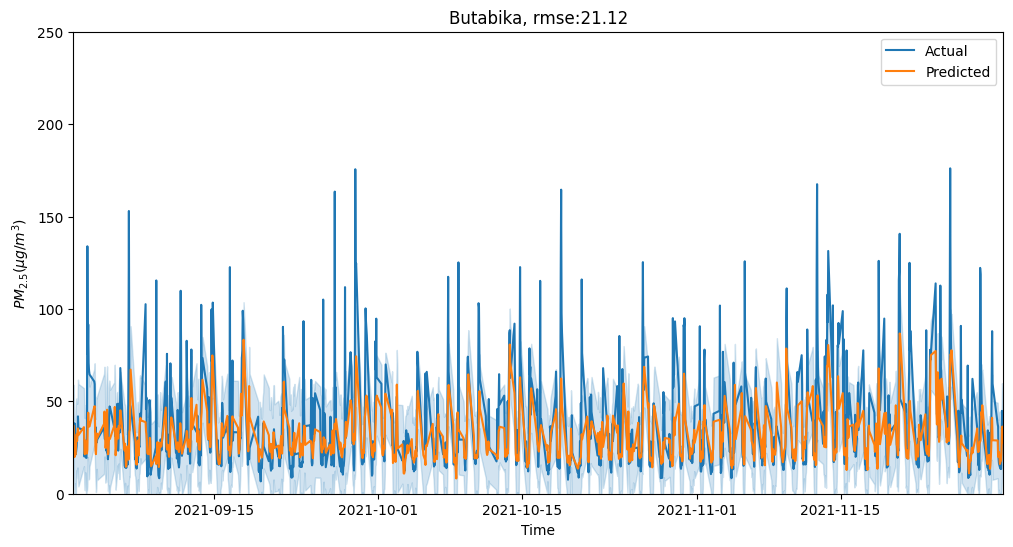

870147 - Nansana West ward successful


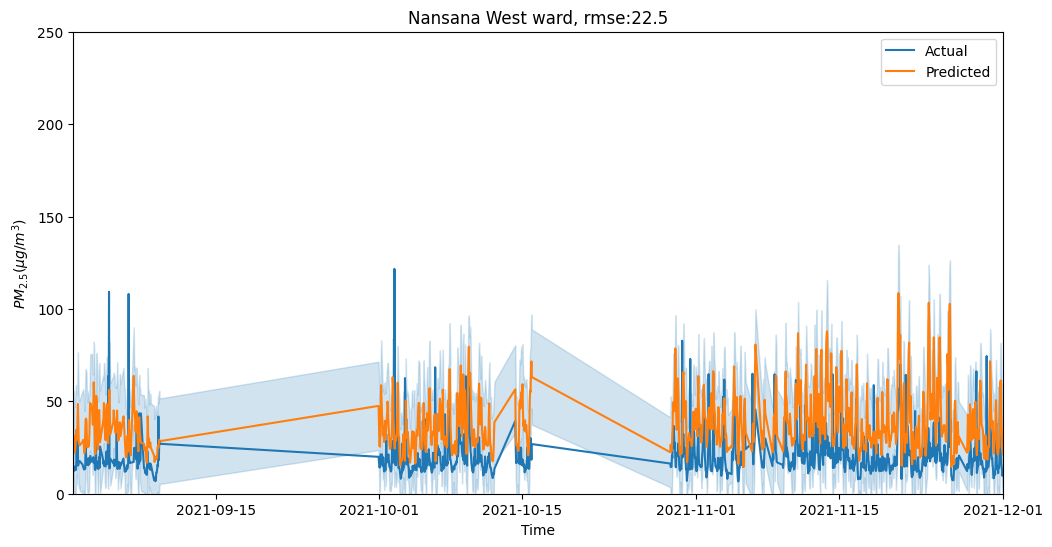

870142 - Nansana East ward successful


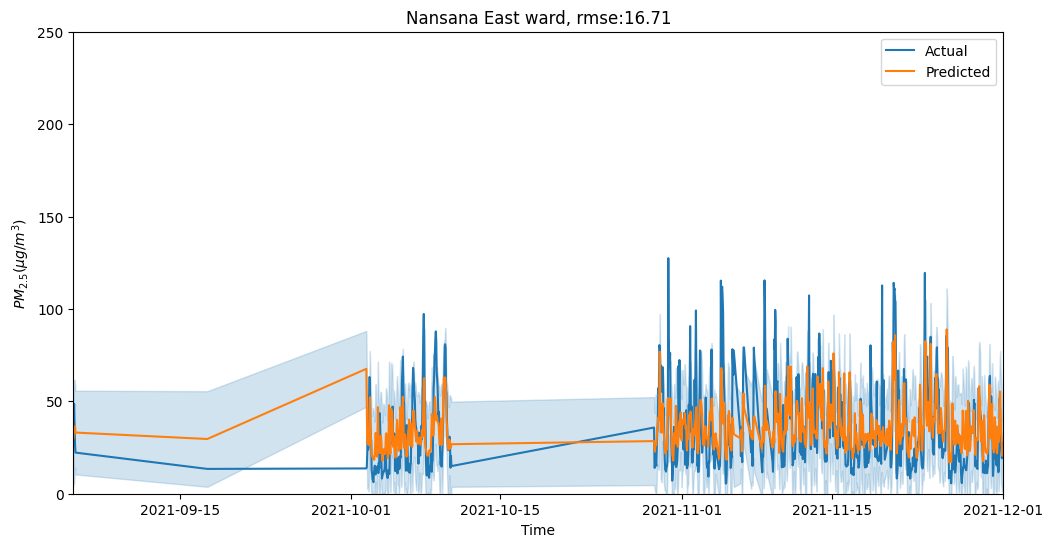

832255 - Busega successful


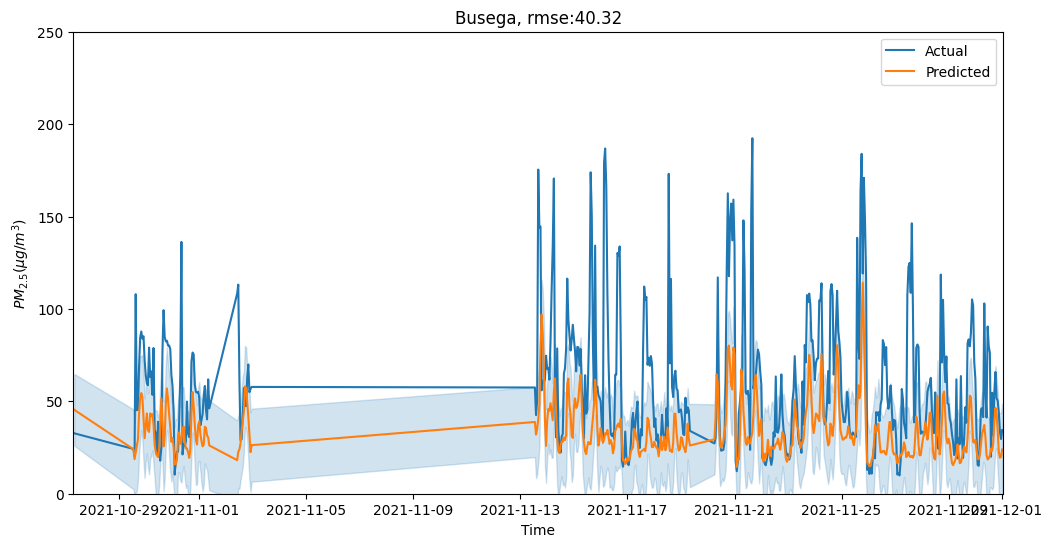

832252 - Busabala successful


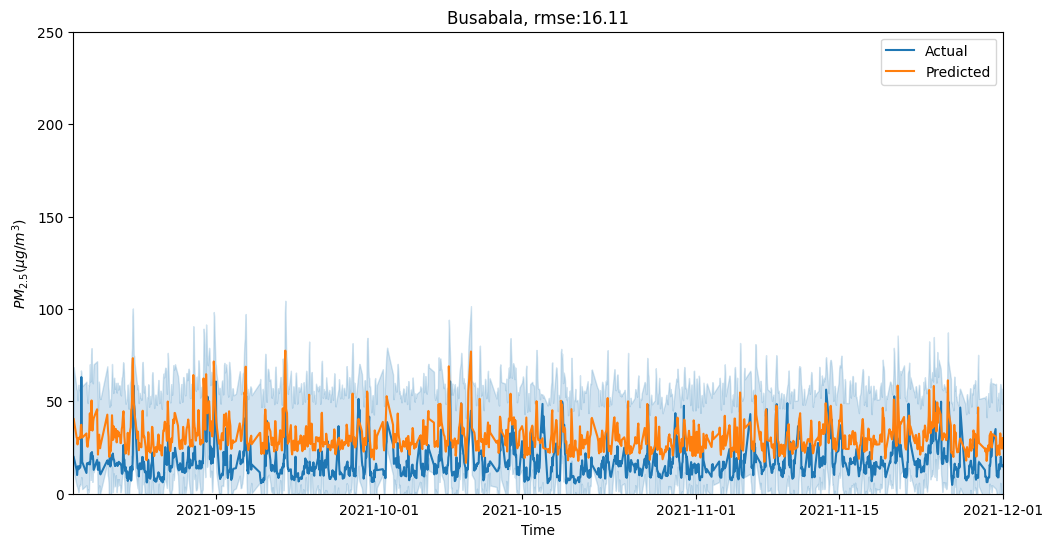

832253 - Mutundwe successful


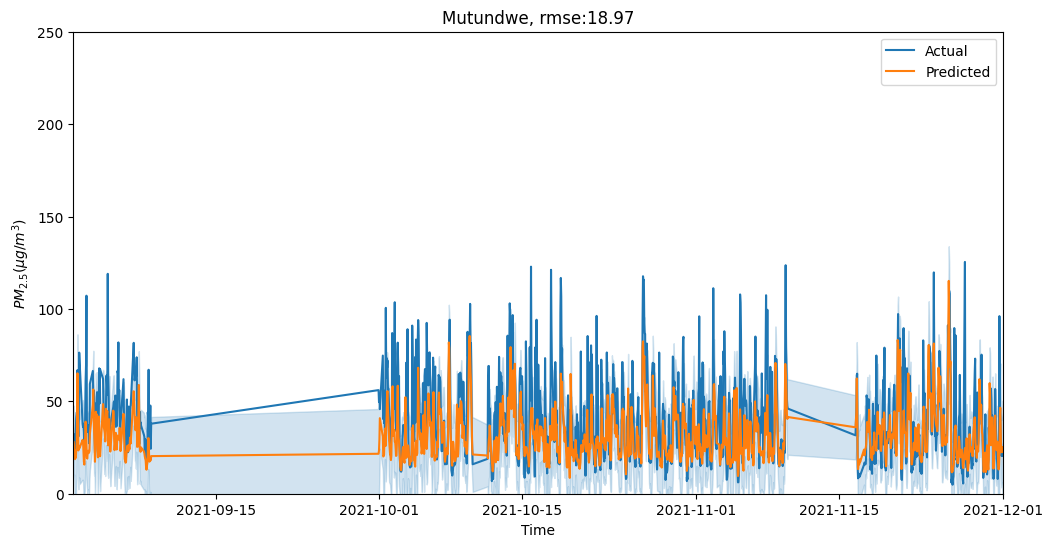

832254 - Kalerwe successful


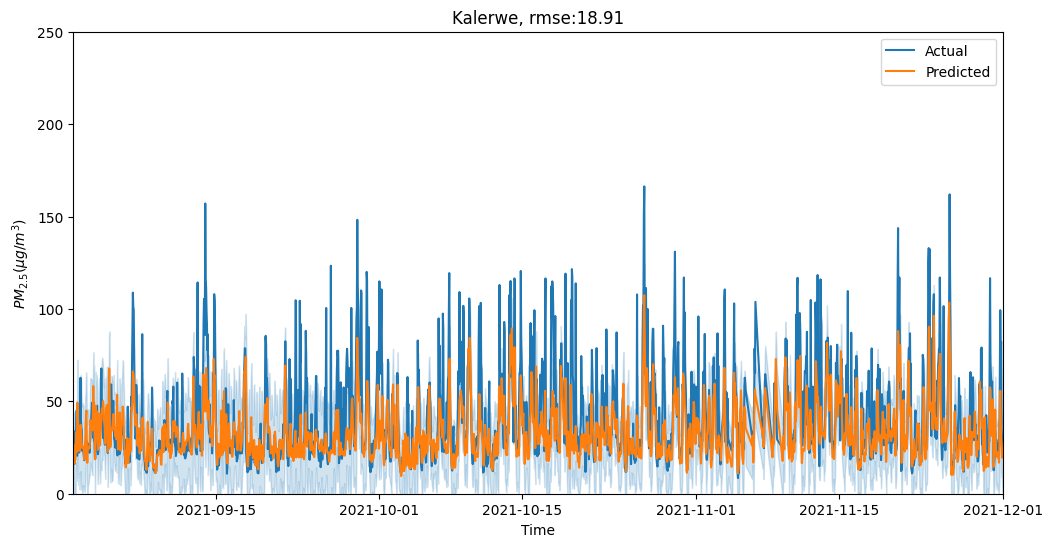

832251 - Nsambya successful


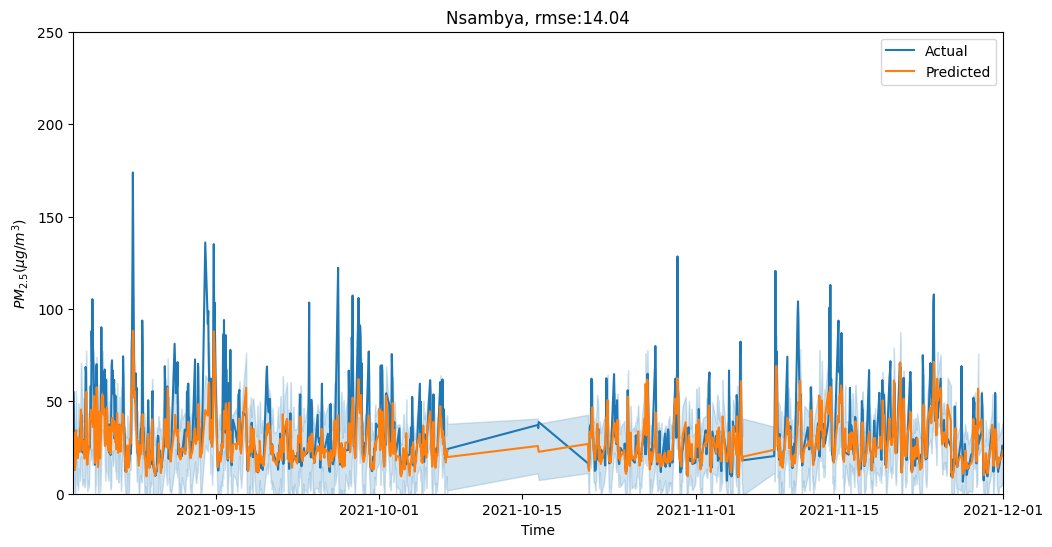

782720 - Bukoto I successful


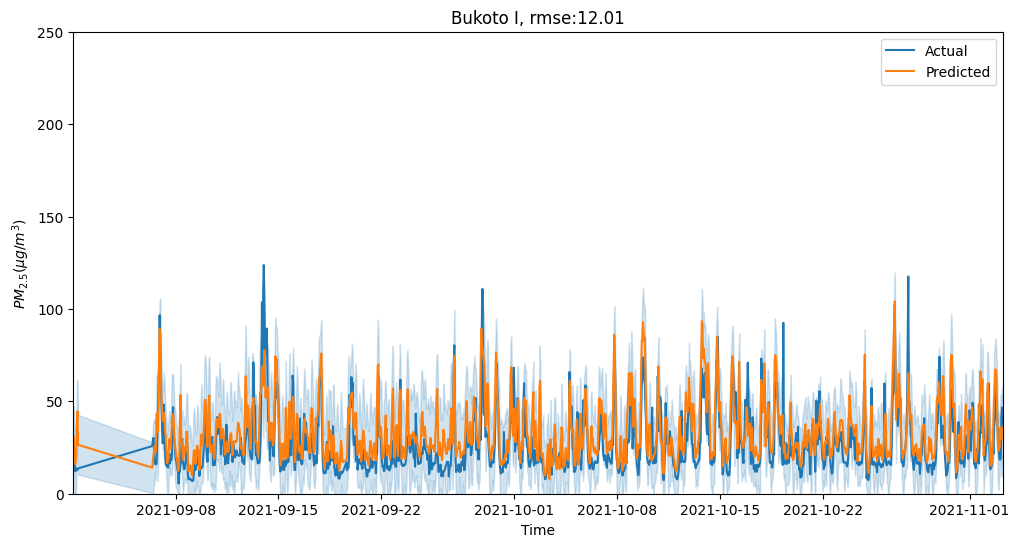

782719 - Bukasa successful


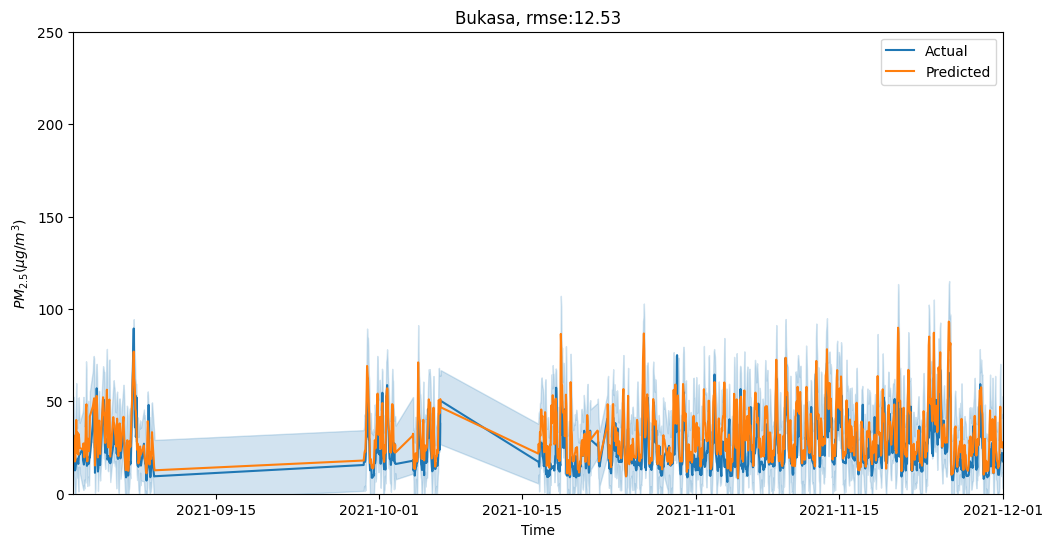

782718 - Kasubi successful


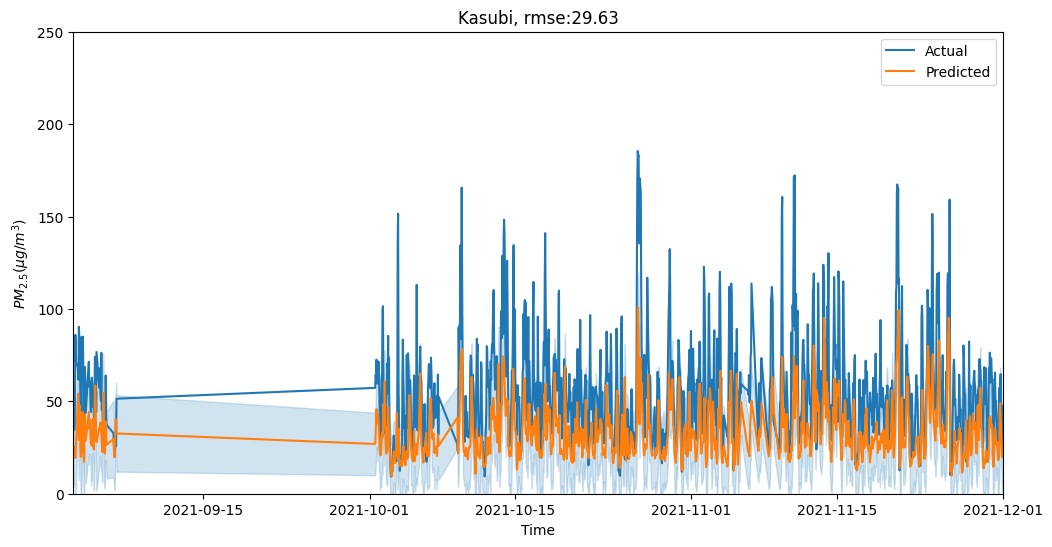

755614 - Naguru II successful


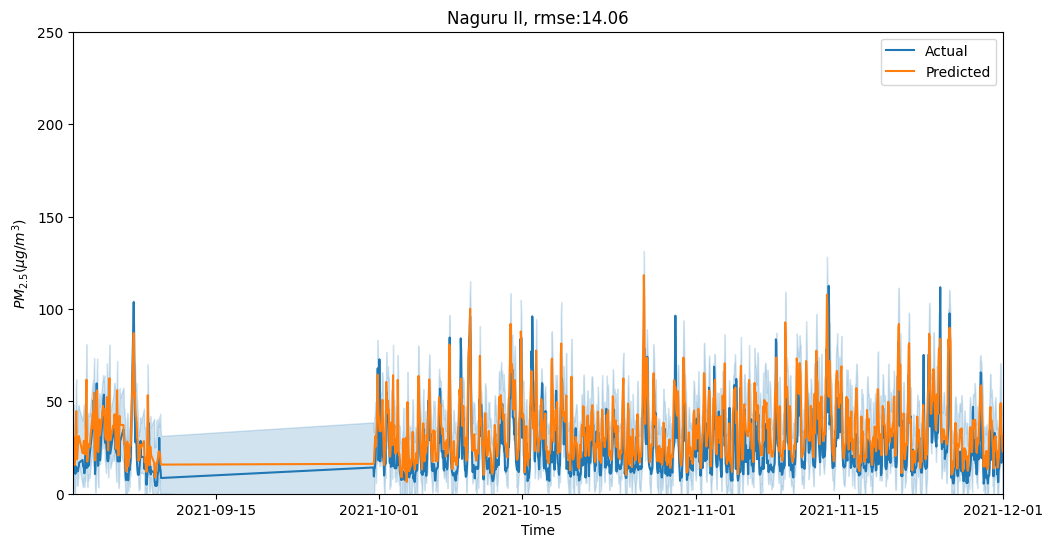

755612 - Lukuli successful


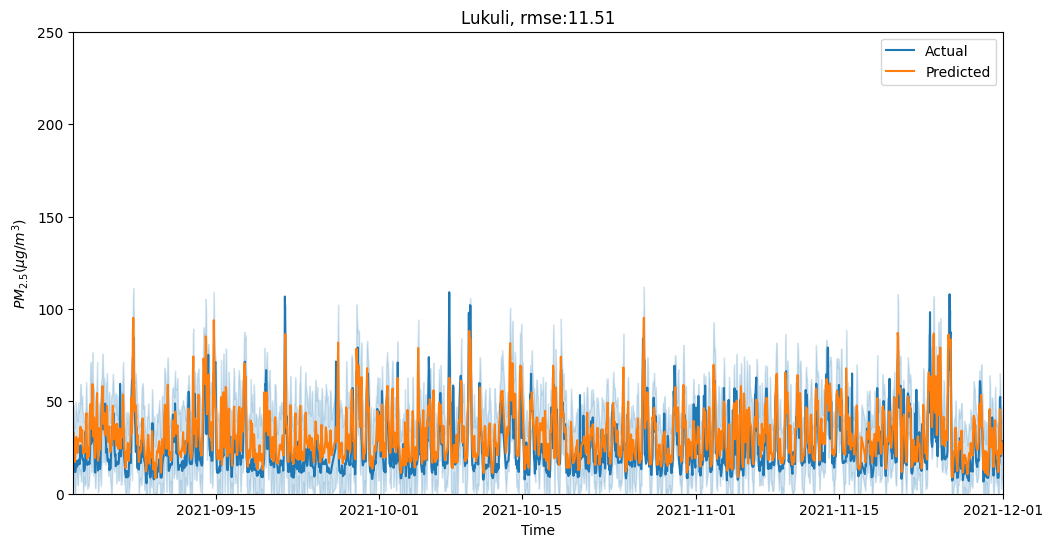

870146 - Makerere University_01 successful


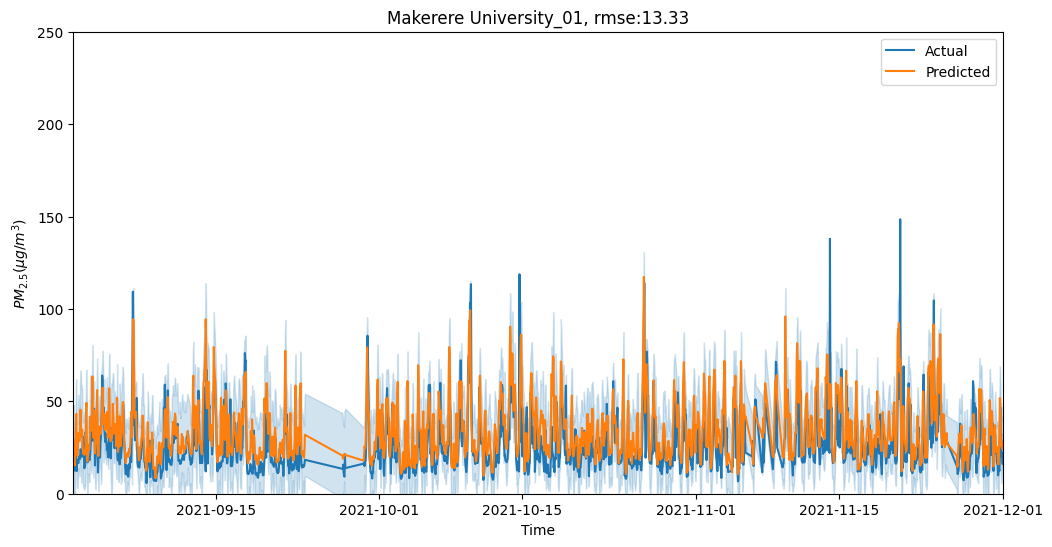

737276 - Rubaga successful


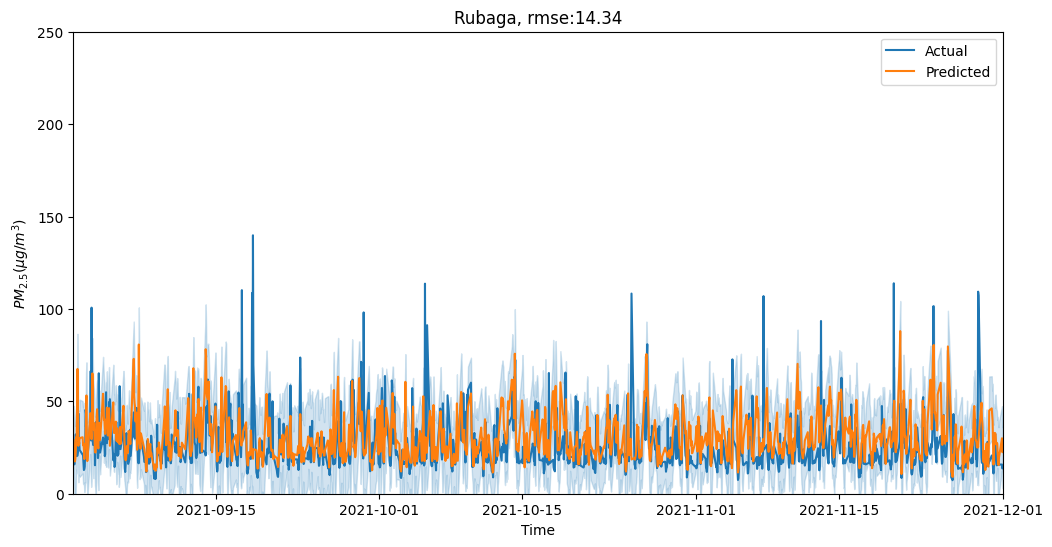

737273 - Bweyogerere successful


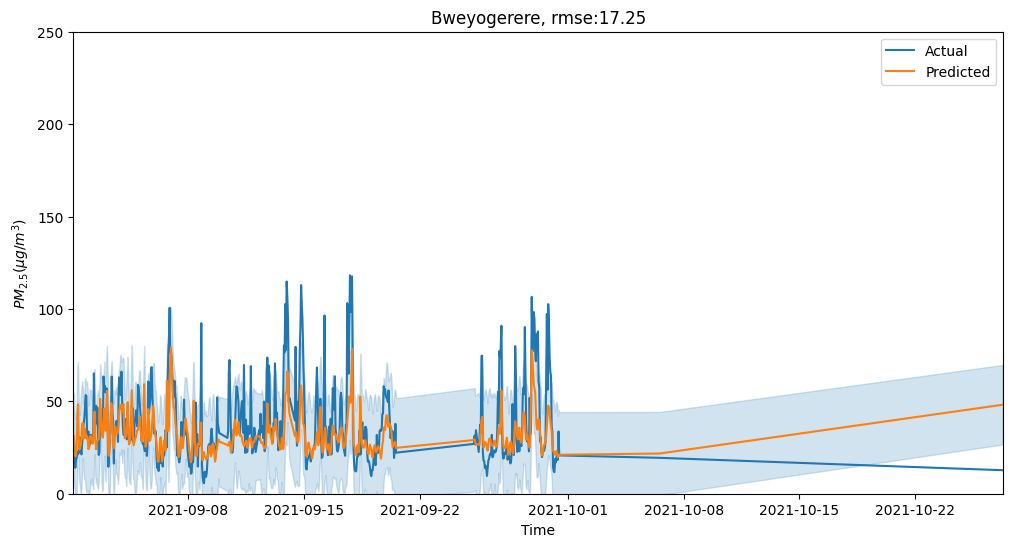

689761 - Bweyogerere_02 successful


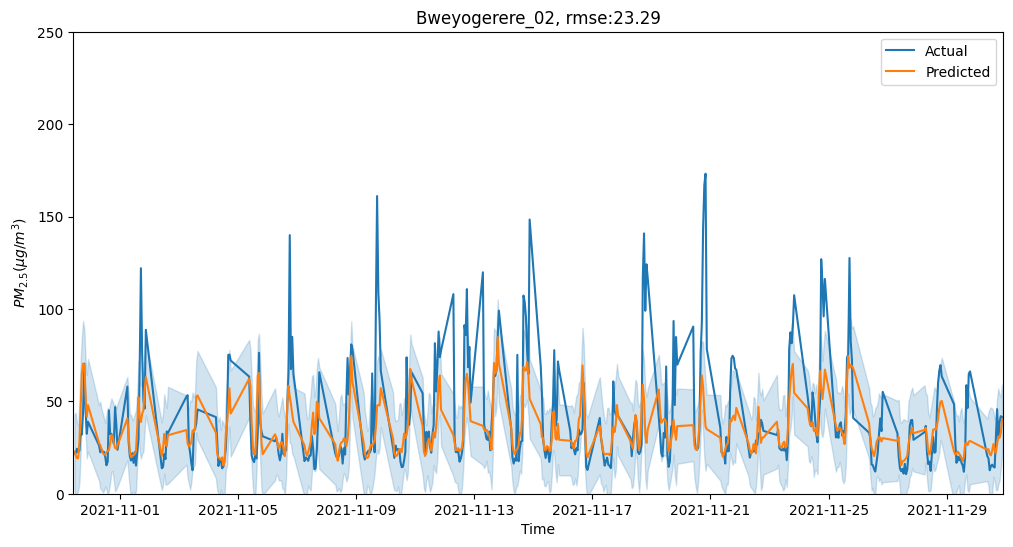

718029 - Civic centre successful


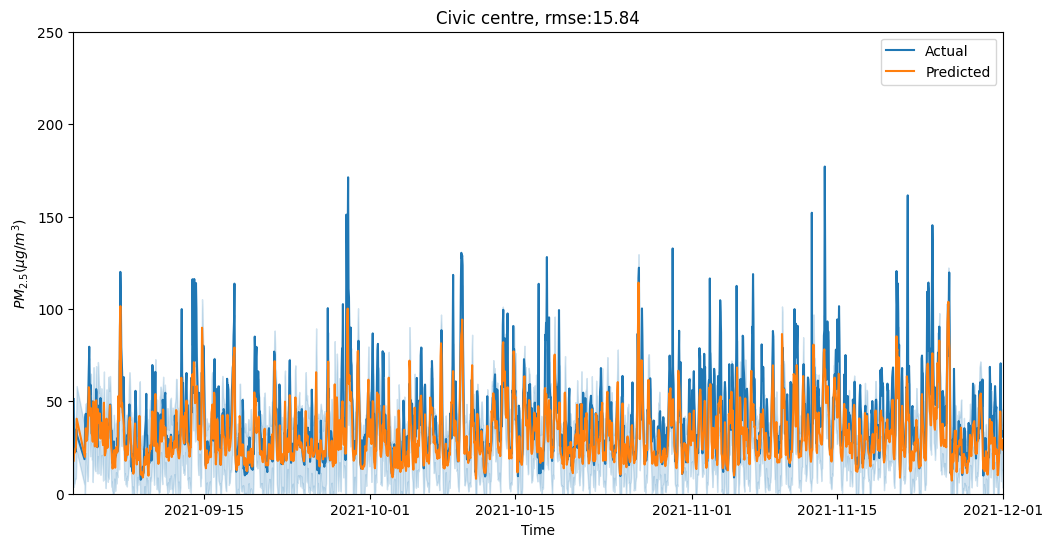

782721 - Kiwafu ward successful


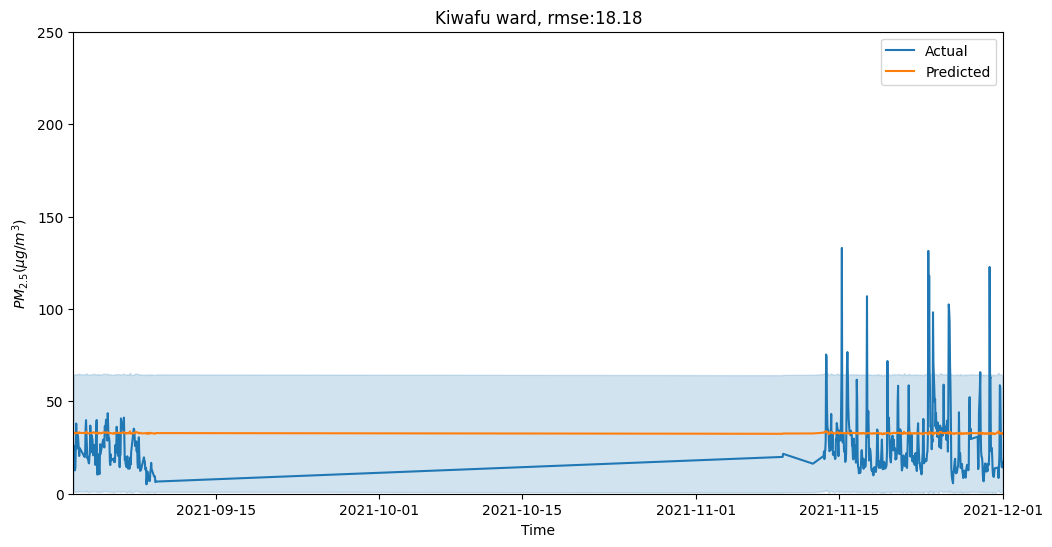

782722 - Seguku successful


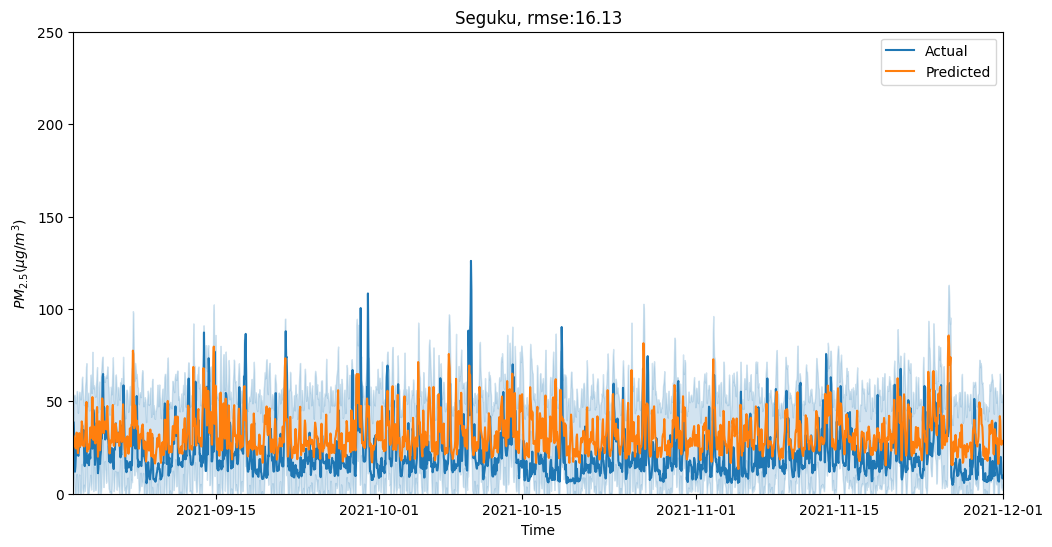

912219 - Lukuli_02 successful


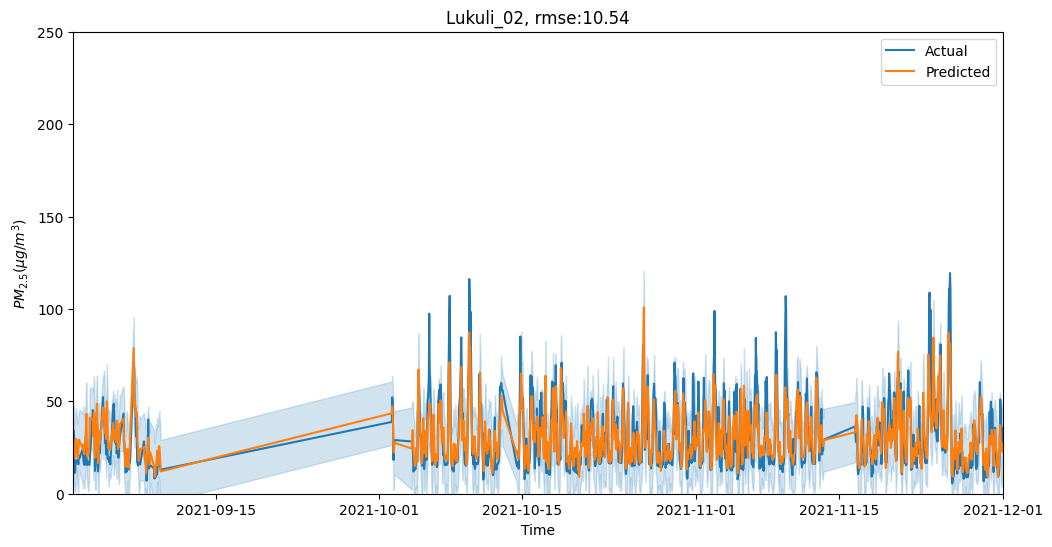

912221 - Najera successful


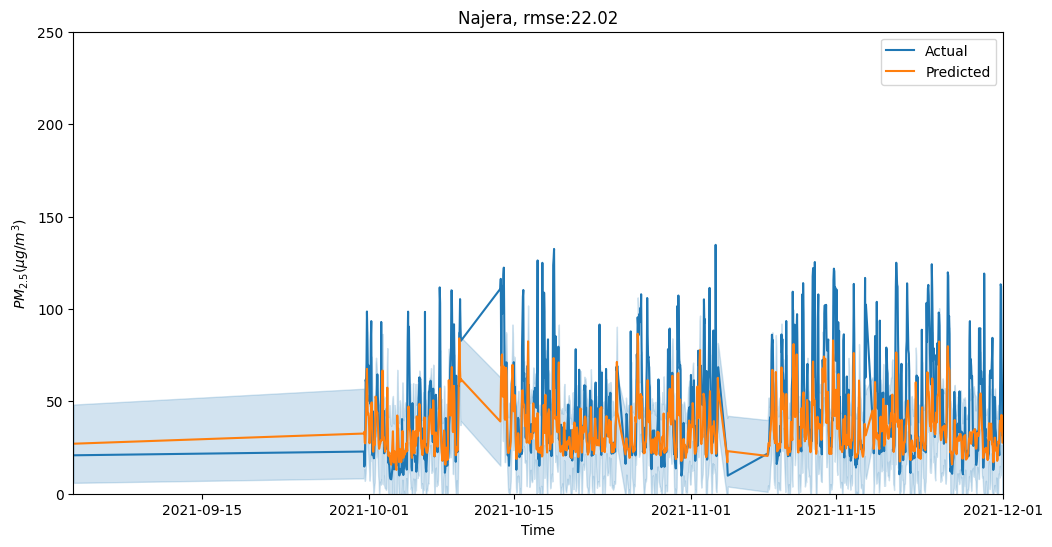

912225 - Kasenge successful


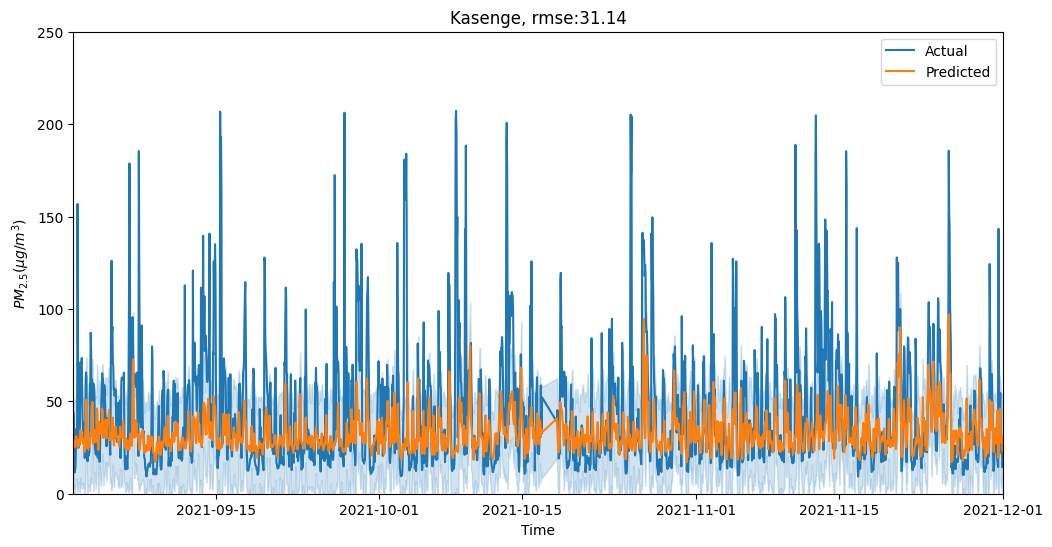

930429 - Kisugu successful


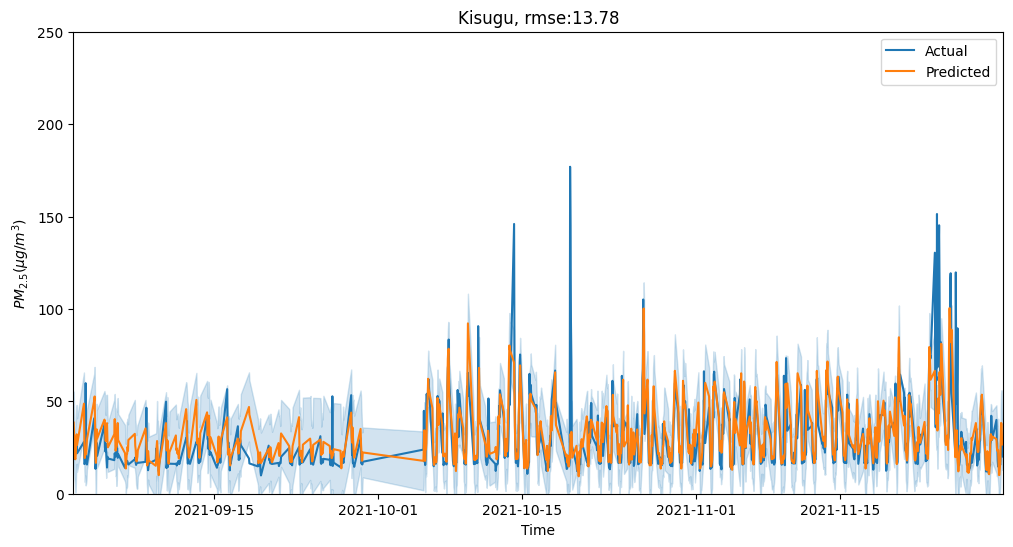

{'lengthscale': [1, 0.08, 0.08], 'likelihood_variance': 400, 'kernel_variance': 625, 'trainable_kernel': True, 'trainable_variance': True, 'trainable_lengthscale': False, 'avg_rmse': 18.323266134718057, 'rmse_list': [12.549445951467574, 12.411611340509312, 11.41341888429773, 13.86719407442642, 21.667059274847514, 20.56825776459036, 17.54651907273299, 13.128204226257745, 36.943414699273085, 18.63449134732769, 21.118661355341246, 22.495519849733693, 16.71238018803243, 40.319705982001615, 16.10923939005971, 18.970083338736092, 18.912733815568437, 14.04221503246313, 12.006668690292585, 12.533757449975477, 29.627608547279888, 14.055738981446122, 11.51427085243903, 13.328384545900182, 14.3352798724628, 17.246424589458503, 23.29413136214671, 15.840293402303036, 18.184540967174655, 16.132992284695543, 10.541216223291801, 22.024865682091335, 31.139211193467624, 13.775508348321841], 'avg_mape': 0.44178662943504077, 'mape_list': [0.3797529938355449, 0.510118090834068, 0.5739844086377818, 0.520454

In [19]:
results_df = pd.DataFrame()
rmse_list = []
mape_list = []
for i in range(len(site_names)):
    try:
        rmse, mape, mean, var, X_test, y_test = cross_validation(final_df, i, kernel_variance, lengthscale, 
                                                                 likelihood_variance, trainable_kernel, 
                                                                 trainable_variance, trainable_lengthscale)
        rmse_list.append(rmse)
        mape_list.append(mape)
        print(f'{device_ids[i]} - {new_site_names[i]} successful')
        plt.figure(figsize=(12,6))
        plt.title(f'{new_site_names[i]}, rmse:{round(rmse, 2)}')
        plt.xlim(f2(X_test[:,0]).min()-timedelta(hours=1), f2(X_test[:,0]).max()+timedelta(hours=1))
        plt.ylim(0, 250)
        plt.xlabel('Time')
        plt.ylabel('$PM_{2.5} (\mu g/m^3)$')
        plt.plot(f2(X_test[:, 0]), y_test, label='Actual')
        plt.plot(f2(X_test[:, 0]), mean, label='Predicted')
        plt.fill_between(f2(X_test[:, 0]),
                         mean[:,0]-1.96*np.sqrt(var[:, 0]),
                         mean[:,0]+1.96*np.sqrt(var[:, 0]),
                         color="C0",
                         alpha=0.2)
        plt.legend(loc='best')
        plt.savefig(f'../plots/final/{new_site_names[i]}.png') 
        plt.show()
    except Exception as e:
        print(e)
        print(f'{device_ids[i]} - {new_site_names[i]} failed')
        break

mean_rmse = np.mean(rmse_list)
mean_mape = np.mean(mape_list)
results_dict= {'lengthscale':lengthscale, 'likelihood_variance':likelihood_variance, 
               'kernel_variance':kernel_variance, 'trainable_kernel':trainable_kernel, 
               'trainable_variance':trainable_variance, 'trainable_lengthscale':trainable_lengthscale, 
               'avg_rmse':mean_rmse, 'rmse_list':rmse_list, 'avg_mape':mean_mape, 'mape_list':mape_list}
print(results_dict)
results_df = results_df.append(results_dict, ignore_index=True)
results_df.to_csv(f'../results/final_results_with_plots.csv', index=False)               

In [20]:
np.mean(rmse_list), np.std(rmse_list), np.median(rmse_list), np.min(rmse_list), np.max(rmse_list)

(18.323266134718057,
 6.997560305275731,
 16.422686236363987,
 10.541216223291801,
 40.319705982001615)

In [21]:
rmse_list

[12.549445951467574,
 12.411611340509312,
 11.41341888429773,
 13.86719407442642,
 21.667059274847514,
 20.56825776459036,
 17.54651907273299,
 13.128204226257745,
 36.943414699273085,
 18.63449134732769,
 21.118661355341246,
 22.495519849733693,
 16.71238018803243,
 40.319705982001615,
 16.10923939005971,
 18.970083338736092,
 18.912733815568437,
 14.04221503246313,
 12.006668690292585,
 12.533757449975477,
 29.627608547279888,
 14.055738981446122,
 11.51427085243903,
 13.328384545900182,
 14.3352798724628,
 17.246424589458503,
 23.29413136214671,
 15.840293402303036,
 18.184540967174655,
 16.132992284695543,
 10.541216223291801,
 22.024865682091335,
 31.139211193467624,
 13.775508348321841]

In [22]:
mape_list

[0.3797529938355449,
 0.510118090834068,
 0.5739844086377818,
 0.5204543199689065,
 0.29589153228959325,
 0.25449882143851044,
 0.3833636887477713,
 0.3472467952385314,
 0.35340333736469254,
 0.27965101867588815,
 0.3271639647726146,
 1.0568356895416584,
 0.5019876759385303,
 0.38731704513647086,
 1.1172138938616167,
 0.31480975977739906,
 0.27040803823160814,
 0.22944250172947836,
 0.42563519533529665,
 0.47879892170212973,
 0.3667923219600145,
 0.5833928623890077,
 0.46332922498845547,
 0.45048354748111524,
 0.4182742477098391,
 0.30518662454367373,
 0.29308484770380255,
 0.2381136643316901,
 0.7767713426366327,
 0.8676455990149715,
 0.29310362948872304,
 0.298334033494823,
 0.38767060193075314,
 0.27058516005979283]

In [23]:
np.mean(mape_list)

0.44178662943504077

In [ ]:
site_names

#### Location details

In [ ]:
site_names[10]

In [ ]:
closest_to_mean = min(rmse_list, key=lambda x:abs(x-np.mean(rmse_list)))
closest_to_mean

In [ ]:
len(kampala_devices)

In [ ]:
a = [17.465856759510825,
 17.385687086753737,
 9.02747009796371,
 16.76569234900266,
 32.19655136690691,
 32.68200800839718,
 22.451368885743914,
 16.607619299551278,
 47.90496828438701,
 28.49756491447449,
 29.689442781825875,
 11.854366968984534,
 25.367152612002496,
 51.773125682816854,
 10.31313437620305,
 28.88156040192427,
 31.37472084194784,
 22.543381301999567,
 16.728563854462,
 12.254202608386349,
 43.495043943606376,
 15.88315979314722,
 16.126768503129064,
 15.327444078912423,
 14.336387722834965, 
     34.280260070027914,
 28.74075195178279,
 17.2749002942356,
 14.031043919874433,
 19.944318699536264,
 35.43889850635527,
 19.78623786221712,
 39.30660136838102]
np.mean(a), np.std(a), np.median(a), np.min(a), np.max(a)